# Circuit learning module: Lambeq manually with SPSA and JAX

This module performs the optimization of the parametrized circuit manually compared to Lambeq's automatic QuantumTrainer class. I created this because I wanted to have more control over the optimization process and debug it better. The code is based on the workflow presented in https://github.com/CQCL/Quanthoven.

In [1]:
import warnings
import json
import os
import sys
import glob
from math import ceil
from pathlib import Path
from jax import numpy as np
from sympy import default_sort_key
import numpy
import pickle
import matplotlib.pyplot as plt

import jax
from jax import jit
from noisyopt import minimizeSPSA, minimizeCompass

from discopy.quantum import Circuit
from discopy.tensor import Tensor
from discopy.utils import loads
#from pytket.extensions.qiskit import AerBackend
#from pytket.extensions.qulacs import QulacsBackend
#from pytket.extensions.cirq import CirqStateSampleBackend
backend = None

from utils import *
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

warnings.filterwarnings('ignore')
this_folder = os.path.abspath(os.getcwd())
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
#os.environ["JAX_PLATFORMS"] = "cpu"

EPOCHS = 500
SEED = 0

# This avoids TracerArrayConversionError from jax
Tensor.np = np

rng = numpy.random.default_rng(SEED)
numpy.random.seed(SEED)

## Read circuit data

We read the circuits from the pickled files. Select if we perform binary classification or multi-class classification. Give number of qubits to create classes:
- 1 qubits -> 2^1 = 2 classes i.e. binary classification
- 2 qubits -> 2^2 = 4 classes
- ...
- 5 qubits -> 2^5 = 32 classes, etc.

In [2]:
# Select workload
workload = "execution_time"
#workload = "cardinality"

# Select workload size
#workload_size = "small"
#workload_size = "medium"
#workload_size = "large"
workload_size = "main"

classification = 1
layers = 1
single_qubit_params = 3
n_wire_count = 1

loss = multi_class_loss
acc = multi_class_acc

if classification == 1:
    loss = bin_class_loss
    acc = bin_class_acc

# Access the selected circuits
path_name = this_folder + "//simplified-JOB-diagrams//" + workload + "//" + workload_size + "//circuits//" + str(classification) + "//" + str(layers) + "_layer//" + str(single_qubit_params) + "_single_qubit_params//" + str(n_wire_count) + "_n_wire_count//"

training_circuits_paths = glob.glob(path_name + "training//[0-9]*.p")
validation_circuits_paths = glob.glob(path_name + "validation//[0-9]*.p")
test_circuits_paths = glob.glob(path_name + "test//[0-9]*.p")

In [3]:
training_circuits = read_diagrams(training_circuits_paths)
validation_circuits = read_diagrams(validation_circuits_paths)
test_circuits = read_diagrams(test_circuits_paths)

## Read training and test data

In [4]:
training_data, test_data, validation_data = None, None, None
data_path = this_folder + "//data//" + workload + "//" + workload_size + "//"

with open(data_path + "training_data.json", "r") as inputfile:
    training_data = json.load(inputfile)['training_data']
with open(data_path + "test_data.json", "r") as inputfile:
    test_data = json.load(inputfile)['test_data']
with open(data_path + "validation_data.json", "r") as inputfile:
    validation_data = json.load(inputfile)['validation_data']

training_data_labels = create_labeled_classes(training_data, classification, workload)
test_data_labels = create_labeled_classes(test_data, classification, workload)
validation_data_labels = create_labeled_classes(validation_data, classification, workload)

## Lambeq optimizer

## Model

In [5]:
def make_pred_fn(circuits):
    # In the case we want to use other backends. 
    # Currently does not work properly.
    if backend:
        compiled_circuits1 = backend.get_compiled_circuits([c.to_tk() for c in circuits])
        circuits = [Circuit.from_tk(c) for c in compiled_circuits1]
        
    circuit_fns = [c.lambdify(*parameters) for c in circuits]
    
    def predict(params):
        outputs = Circuit.eval(*(c(*params) for c in circuit_fns), backend = backend)
        res = []
        
        for output in outputs:
            predictions = np.abs(output.array) + 1e-9
            ratio = predictions / predictions.sum()
            res.append(ratio)
            
        return np.array(res)
    return predict

## Loss function and evaluation

In [6]:
def make_cost_fn(pred_fn, labels):
    def cost_fn(params, **kwargs):
        predictions = pred_fn(params)

        cost = loss(predictions, labels) #-np.sum(labels * np.log(predictions)) / len(labels)  # binary cross-entropy loss
        costs.append(cost)

        accuracy = acc(predictions, labels) #np.sum(np.round(predictions) == labels) / len(labels) / 2  # half due to double-counting
        accuracies.append(accuracy)

        return cost

    costs, accuracies = [], []
    return cost_fn, costs, accuracies

## Minimization with noisyopt

In [7]:
def initialize_parameters(old_params, old_values, new_params):
    new_values = list(numpy.array(rng.random(len(new_params))))
    old_param_dict = {}
    for p, v in zip(old_params, old_values):
        old_param_dict[p] = v
        
    parameters = sorted(set(old_params + new_params), key=default_sort_key)
    values = []
    for p in parameters:
        if p in old_param_dict:
            values.append(old_param_dict[p])
        else:
            values.append(new_values.pop())
            
    return parameters, np.array(values)

In [8]:
EPOCHS = 4000
initial_number_of_circuits = 415
syms = {}
limit = False
all_training_keys = list(training_circuits.keys())
initial_circuit_keys = all_training_keys[:initial_number_of_circuits + 1]
current_training_circuits = {}
result_file = workload_size + "_noisyopt_2" + str(classification) + "_" + str(layers) + "_" + str(single_qubit_params)

for k in initial_circuit_keys:
    current_training_circuits[k] = training_circuits[k]
    
syms = get_symbols(current_training_circuits)
parameters = sorted(syms, key=default_sort_key)
if initial_number_of_circuits > 5 and os.path.exists("points//" + result_file + ".npz"):
    with open("points//" + result_file + ".npz", "rb") as f:
        print("Loading parameters from file " + result_file)
        npzfile = np.load(f)
        init_params_spsa = npzfile['arr_0']
else:
    print("Initializing new parameters")
    init_params_spsa = np.array(rng.random(len(parameters)))
result = None
run = 0

Loading parameters from file main_noisyopt_21_1_3


Progress:  0.926
Number of training circuits: 414   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 286


Epoch: 200   train/loss: 0.3146   valid/loss: 0.3846   train/acc: 0.8575   valid/acc: 0.8673
Epoch: 400   train/loss: 0.2861   valid/loss: 0.3918   train/acc: 0.8841   valid/acc: 0.8673
Epoch: 600   train/loss: 0.2718   valid/loss: 0.3935   train/acc: 0.8913   valid/acc: 0.8673
Epoch: 800   train/loss: 0.2939   valid/loss: 0.3941   train/acc: 0.8865   valid/acc: 0.8673
Epoch: 1000   train/loss: 0.2735   valid/loss: 0.3933   train/acc: 0.8937   valid/acc: 0.8673
Epoch: 1200   train/loss: 0.2827   valid/loss: 0.3934   train/acc: 0.8913   valid/acc: 0.8673
Epoch: 1400   train/loss: 0.3   valid/loss: 0.3955   train/acc: 0.8816   valid/acc: 0.8673
Epoch: 1600   train/loss: 0.2788   valid/loss: 0.3962   train/acc: 0.8865   valid/acc: 0.8673
Epoch: 1800   train/loss: 0.2891   valid/loss: 0.3955   train/acc: 0.8768   valid/acc: 0.8584
Epoch: 2000   train/loss: 0.2755   valid/loss: 0.395   train/acc: 0.8889   valid/acc: 0.8673
Epoch: 2200   train/loss: 0.2828   valid/loss: 0.3966   train/acc: 0

Test accuracy: 0.7857143
Progress:  0.929
Number of training circuits: 415   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 286


Epoch: 200   train/loss: 0.2929   valid/loss: 0.3982   train/acc: 0.8747   valid/acc: 0.8584
Epoch: 400   train/loss: 0.3074   valid/loss: 0.4051   train/acc: 0.8651   valid/acc: 0.8584
Epoch: 600   train/loss: 0.2769   valid/loss: 0.4028   train/acc: 0.8867   valid/acc: 0.8584
Epoch: 800   train/loss: 0.2726   valid/loss: 0.4056   train/acc: 0.8843   valid/acc: 0.8496
Epoch: 1000   train/loss: 0.2985   valid/loss: 0.4057   train/acc: 0.8723   valid/acc: 0.8673
Epoch: 1200   train/loss: 0.2705   valid/loss: 0.406   train/acc: 0.8916   valid/acc: 0.8673
Epoch: 1400   train/loss: 0.2814   valid/loss: 0.4054   train/acc: 0.8843   valid/acc: 0.8673
Epoch: 1600   train/loss: 0.2753   valid/loss: 0.4064   train/acc: 0.8819   valid/acc: 0.8673
Epoch: 1800   train/loss: 0.2751   valid/loss: 0.4097   train/acc: 0.8988   valid/acc: 0.8673
Epoch: 2000   train/loss: 0.2754   valid/loss: 0.4098   train/acc: 0.8892   valid/acc: 0.8673
Epoch: 2200   train/loss: 0.2915   valid/loss: 0.4111   train/acc

Test accuracy: 0.79464287
Progress:  0.931
Number of training circuits: 416   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 286


Epoch: 200   train/loss: 0.2781   valid/loss: 0.4213   train/acc: 0.8894   valid/acc: 0.8584
Epoch: 400   train/loss: 0.3098   valid/loss: 0.4166   train/acc: 0.8726   valid/acc: 0.8673
Epoch: 600   train/loss: 0.2856   valid/loss: 0.4302   train/acc: 0.8846   valid/acc: 0.8673
Epoch: 800   train/loss: 0.2765   valid/loss: 0.4305   train/acc: 0.8894   valid/acc: 0.8673
Epoch: 1000   train/loss: 0.3086   valid/loss: 0.4245   train/acc: 0.8678   valid/acc: 0.8673
Epoch: 1200   train/loss: 0.2738   valid/loss: 0.4221   train/acc: 0.887   valid/acc: 0.8673
Epoch: 1400   train/loss: 0.27   valid/loss: 0.4296   train/acc: 0.8918   valid/acc: 0.8673
Epoch: 1600   train/loss: 0.2781   valid/loss: 0.4311   train/acc: 0.8918   valid/acc: 0.8673
Epoch: 1800   train/loss: 0.2709   valid/loss: 0.4279   train/acc: 0.8846   valid/acc: 0.8673
Epoch: 2000   train/loss: 0.2767   valid/loss: 0.4265   train/acc: 0.8894   valid/acc: 0.8673
Epoch: 2200   train/loss: 0.2845   valid/loss: 0.4315   train/acc: 

Test accuracy: 0.7857143
Progress:  0.933
Number of training circuits: 417   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 286


Epoch: 200   train/loss: 0.2784   valid/loss: 0.4152   train/acc: 0.8825   valid/acc: 0.8673
Epoch: 400   train/loss: 0.289   valid/loss: 0.4129   train/acc: 0.8921   valid/acc: 0.8761
Epoch: 600   train/loss: 0.3082   valid/loss: 0.4152   train/acc: 0.8801   valid/acc: 0.8761
Epoch: 800   train/loss: 0.2746   valid/loss: 0.4155   train/acc: 0.8897   valid/acc: 0.8761
Epoch: 1000   train/loss: 0.2917   valid/loss: 0.4135   train/acc: 0.8921   valid/acc: 0.8761
Epoch: 1200   train/loss: 0.2901   valid/loss: 0.4159   train/acc: 0.8849   valid/acc: 0.8673
Epoch: 1400   train/loss: 0.2737   valid/loss: 0.4135   train/acc: 0.8921   valid/acc: 0.8673
Epoch: 1600   train/loss: 0.2785   valid/loss: 0.4149   train/acc: 0.8921   valid/acc: 0.8761
Epoch: 1800   train/loss: 0.2993   valid/loss: 0.4147   train/acc: 0.8897   valid/acc: 0.8673
Epoch: 2000   train/loss: 0.2937   valid/loss: 0.4171   train/acc: 0.8753   valid/acc: 0.8673
Epoch: 2200   train/loss: 0.2676   valid/loss: 0.4164   train/acc

Test accuracy: 0.7857143
Progress:  0.935
Number of training circuits: 418   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 286


Epoch: 200   train/loss: 0.2897   valid/loss: 0.4329   train/acc: 0.8756   valid/acc: 0.8673
Epoch: 400   train/loss: 0.2922   valid/loss: 0.4223   train/acc: 0.8852   valid/acc: 0.8673
Epoch: 600   train/loss: 0.2978   valid/loss: 0.429   train/acc: 0.8828   valid/acc: 0.8673
Epoch: 800   train/loss: 0.3018   valid/loss: 0.4229   train/acc: 0.878   valid/acc: 0.8673
Epoch: 1000   train/loss: 0.3003   valid/loss: 0.4184   train/acc: 0.8852   valid/acc: 0.8673
Epoch: 1200   train/loss: 0.3001   valid/loss: 0.4258   train/acc: 0.8852   valid/acc: 0.8673
Epoch: 1400   train/loss: 0.3075   valid/loss: 0.4276   train/acc: 0.8804   valid/acc: 0.8673
Epoch: 1600   train/loss: 0.2963   valid/loss: 0.4247   train/acc: 0.878   valid/acc: 0.8673
Epoch: 1800   train/loss: 0.2967   valid/loss: 0.4205   train/acc: 0.8756   valid/acc: 0.8673
Epoch: 2000   train/loss: 0.2885   valid/loss: 0.4248   train/acc: 0.878   valid/acc: 0.8673
Epoch: 2200   train/loss: 0.2855   valid/loss: 0.4217   train/acc: 0

Test accuracy: 0.79464287
Progress:  0.938
Number of training circuits: 419   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 286


Epoch: 200   train/loss: 0.3031   valid/loss: 0.4307   train/acc: 0.8759   valid/acc: 0.8584
Epoch: 400   train/loss: 0.2778   valid/loss: 0.4446   train/acc: 0.8902   valid/acc: 0.8673
Epoch: 600   train/loss: 0.2933   valid/loss: 0.4336   train/acc: 0.8807   valid/acc: 0.8673
Epoch: 800   train/loss: 0.2876   valid/loss: 0.435   train/acc: 0.8831   valid/acc: 0.8673
Epoch: 1000   train/loss: 0.299   valid/loss: 0.4272   train/acc: 0.8783   valid/acc: 0.8673
Epoch: 1200   train/loss: 0.2938   valid/loss: 0.4265   train/acc: 0.8926   valid/acc: 0.8673
Epoch: 1400   train/loss: 0.3039   valid/loss: 0.4211   train/acc: 0.8616   valid/acc: 0.8673
Epoch: 1600   train/loss: 0.2799   valid/loss: 0.4238   train/acc: 0.8831   valid/acc: 0.8673
Epoch: 1800   train/loss: 0.2949   valid/loss: 0.4222   train/acc: 0.8878   valid/acc: 0.8673
Epoch: 2000   train/loss: 0.2795   valid/loss: 0.4226   train/acc: 0.8878   valid/acc: 0.8673
Epoch: 2200   train/loss: 0.2919   valid/loss: 0.424   train/acc: 

Test accuracy: 0.7857143
Progress:  0.94
Number of training circuits: 420   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 286


Epoch: 200   train/loss: 0.2905   valid/loss: 0.4145   train/acc: 0.8881   valid/acc: 0.8584
Epoch: 400   train/loss: 0.2966   valid/loss: 0.4129   train/acc: 0.869   valid/acc: 0.8584
Epoch: 600   train/loss: 0.2886   valid/loss: 0.4151   train/acc: 0.8762   valid/acc: 0.8584
Epoch: 800   train/loss: 0.2733   valid/loss: 0.4164   train/acc: 0.8905   valid/acc: 0.8584
Epoch: 1000   train/loss: 0.2767   valid/loss: 0.4165   train/acc: 0.8929   valid/acc: 0.8673
Epoch: 1200   train/loss: 0.2944   valid/loss: 0.4179   train/acc: 0.8929   valid/acc: 0.8673
Epoch: 1400   train/loss: 0.2803   valid/loss: 0.4215   train/acc: 0.8786   valid/acc: 0.8584
Epoch: 1600   train/loss: 0.2744   valid/loss: 0.4175   train/acc: 0.8881   valid/acc: 0.8584
Epoch: 1800   train/loss: 0.2762   valid/loss: 0.4183   train/acc: 0.8881   valid/acc: 0.8584
Epoch: 2000   train/loss: 0.2973   valid/loss: 0.4188   train/acc: 0.881   valid/acc: 0.8584
Epoch: 2200   train/loss: 0.2909   valid/loss: 0.4224   train/acc:

Test accuracy: 0.79464287
Progress:  0.942
Number of training circuits: 421   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 286


Epoch: 200   train/loss: 0.2984   valid/loss: 0.4055   train/acc: 0.8717   valid/acc: 0.8673
Epoch: 400   train/loss: 0.3118   valid/loss: 0.4058   train/acc: 0.867   valid/acc: 0.8673
Epoch: 600   train/loss: 0.2868   valid/loss: 0.4071   train/acc: 0.8907   valid/acc: 0.8584
Epoch: 800   train/loss: 0.2895   valid/loss: 0.4115   train/acc: 0.8789   valid/acc: 0.8673
Epoch: 1000   train/loss: 0.2892   valid/loss: 0.4115   train/acc: 0.8955   valid/acc: 0.8584
Epoch: 1200   train/loss: 0.2789   valid/loss: 0.4091   train/acc: 0.8955   valid/acc: 0.8584
Epoch: 1400   train/loss: 0.2815   valid/loss: 0.4072   train/acc: 0.886   valid/acc: 0.8584
Epoch: 1600   train/loss: 0.2736   valid/loss: 0.405   train/acc: 0.8907   valid/acc: 0.8673
Epoch: 1800   train/loss: 0.2793   valid/loss: 0.4057   train/acc: 0.8884   valid/acc: 0.8584
Epoch: 2000   train/loss: 0.2708   valid/loss: 0.4068   train/acc: 0.9002   valid/acc: 0.8673
Epoch: 2200   train/loss: 0.2885   valid/loss: 0.4072   train/acc: 

Test accuracy: 0.77678573
Progress:  0.944
Number of training circuits: 422   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 286


Epoch: 200   train/loss: 0.2891   valid/loss: 0.4321   train/acc: 0.8839   valid/acc: 0.8673
Epoch: 400   train/loss: 0.2806   valid/loss: 0.4346   train/acc: 0.8957   valid/acc: 0.8673
Epoch: 600   train/loss: 0.3037   valid/loss: 0.4331   train/acc: 0.8839   valid/acc: 0.8673
Epoch: 800   train/loss: 0.279   valid/loss: 0.4343   train/acc: 0.8981   valid/acc: 0.8673
Epoch: 1000   train/loss: 0.2915   valid/loss: 0.433   train/acc: 0.8863   valid/acc: 0.8673
Epoch: 1200   train/loss: 0.2828   valid/loss: 0.4386   train/acc: 0.8839   valid/acc: 0.8673
Epoch: 1400   train/loss: 0.2764   valid/loss: 0.4353   train/acc: 0.8768   valid/acc: 0.8673
Epoch: 1600   train/loss: 0.293   valid/loss: 0.4312   train/acc: 0.8673   valid/acc: 0.8673
Epoch: 1800   train/loss: 0.2887   valid/loss: 0.4248   train/acc: 0.8791   valid/acc: 0.8673
Epoch: 2000   train/loss: 0.294   valid/loss: 0.426   train/acc: 0.8863   valid/acc: 0.8673
Epoch: 2200   train/loss: 0.2752   valid/loss: 0.4302   train/acc: 0.

Test accuracy: 0.77678573
Progress:  0.946
Number of training circuits: 423   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 286


Epoch: 200   train/loss: 0.2847   valid/loss: 0.4119   train/acc: 0.8865   valid/acc: 0.8761
Epoch: 400   train/loss: 0.2902   valid/loss: 0.4145   train/acc: 0.8842   valid/acc: 0.8761
Epoch: 600   train/loss: 0.3003   valid/loss: 0.4141   train/acc: 0.8629   valid/acc: 0.8761
Epoch: 800   train/loss: 0.296   valid/loss: 0.4168   train/acc: 0.8913   valid/acc: 0.8761
Epoch: 1000   train/loss: 0.2823   valid/loss: 0.4178   train/acc: 0.8936   valid/acc: 0.8761
Epoch: 1200   train/loss: 0.2667   valid/loss: 0.419   train/acc: 0.8936   valid/acc: 0.8761
Epoch: 1400   train/loss: 0.2953   valid/loss: 0.4196   train/acc: 0.8842   valid/acc: 0.8761
Epoch: 1600   train/loss: 0.296   valid/loss: 0.4207   train/acc: 0.8913   valid/acc: 0.8761
Epoch: 1800   train/loss: 0.2779   valid/loss: 0.4168   train/acc: 0.8889   valid/acc: 0.8761
Epoch: 2000   train/loss: 0.2793   valid/loss: 0.4216   train/acc: 0.8818   valid/acc: 0.8761
Epoch: 2200   train/loss: 0.2984   valid/loss: 0.4202   train/acc: 

Test accuracy: 0.7857143
Progress:  0.949
Number of training circuits: 424   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 286


Epoch: 200   train/loss: 0.2935   valid/loss: 0.4078   train/acc: 0.8821   valid/acc: 0.8673
Epoch: 400   train/loss: 0.2927   valid/loss: 0.409   train/acc: 0.8821   valid/acc: 0.8673
Epoch: 600   train/loss: 0.2763   valid/loss: 0.4114   train/acc: 0.9009   valid/acc: 0.8673
Epoch: 800   train/loss: 0.2801   valid/loss: 0.408   train/acc: 0.8844   valid/acc: 0.8673
Epoch: 1000   train/loss: 0.2965   valid/loss: 0.4108   train/acc: 0.8915   valid/acc: 0.8673
Epoch: 1200   train/loss: 0.2769   valid/loss: 0.4111   train/acc: 0.8844   valid/acc: 0.8673
Epoch: 1400   train/loss: 0.2837   valid/loss: 0.4084   train/acc: 0.8703   valid/acc: 0.8673
Epoch: 1600   train/loss: 0.2971   valid/loss: 0.4112   train/acc: 0.8679   valid/acc: 0.8673
Epoch: 1800   train/loss: 0.2799   valid/loss: 0.4069   train/acc: 0.8892   valid/acc: 0.8673
Epoch: 2000   train/loss: 0.279   valid/loss: 0.4078   train/acc: 0.8844   valid/acc: 0.8673
Epoch: 2200   train/loss: 0.287   valid/loss: 0.4096   train/acc: 0

Test accuracy: 0.7857143
Progress:  0.951
Number of training circuits: 425   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 286


Epoch: 200   train/loss: 0.2893   valid/loss: 0.403   train/acc: 0.8847   valid/acc: 0.8673
Epoch: 400   train/loss: 0.2831   valid/loss: 0.4059   train/acc: 0.8824   valid/acc: 0.8673
Epoch: 600   train/loss: 0.2981   valid/loss: 0.4088   train/acc: 0.8894   valid/acc: 0.8673
Epoch: 800   train/loss: 0.2856   valid/loss: 0.4108   train/acc: 0.8847   valid/acc: 0.8673
Epoch: 1000   train/loss: 0.2854   valid/loss: 0.4131   train/acc: 0.8894   valid/acc: 0.8673
Epoch: 1200   train/loss: 0.283   valid/loss: 0.4161   train/acc: 0.8965   valid/acc: 0.8673
Epoch: 1400   train/loss: 0.2813   valid/loss: 0.4153   train/acc: 0.8776   valid/acc: 0.8673
Epoch: 1600   train/loss: 0.2898   valid/loss: 0.4171   train/acc: 0.8871   valid/acc: 0.8673
Epoch: 1800   train/loss: 0.2732   valid/loss: 0.4149   train/acc: 0.8894   valid/acc: 0.8673
Epoch: 2000   train/loss: 0.293   valid/loss: 0.4146   train/acc: 0.9012   valid/acc: 0.8673
Epoch: 2200   train/loss: 0.2768   valid/loss: 0.4152   train/acc: 

Test accuracy: 0.7857143
Progress:  0.953
Number of training circuits: 426   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 286


Epoch: 200   train/loss: 0.2878   valid/loss: 0.414   train/acc: 0.8732   valid/acc: 0.8673
Epoch: 400   train/loss: 0.3026   valid/loss: 0.4042   train/acc: 0.8873   valid/acc: 0.8673
Epoch: 600   train/loss: 0.2839   valid/loss: 0.407   train/acc: 0.8873   valid/acc: 0.8673
Epoch: 800   train/loss: 0.2975   valid/loss: 0.4051   train/acc: 0.8756   valid/acc: 0.8673
Epoch: 1000   train/loss: 0.2868   valid/loss: 0.4078   train/acc: 0.8756   valid/acc: 0.8673
Epoch: 1200   train/loss: 0.2982   valid/loss: 0.4095   train/acc: 0.8709   valid/acc: 0.8673
Epoch: 1400   train/loss: 0.2783   valid/loss: 0.4124   train/acc: 0.8944   valid/acc: 0.8673
Epoch: 1600   train/loss: 0.2977   valid/loss: 0.4119   train/acc: 0.8803   valid/acc: 0.8673
Epoch: 1800   train/loss: 0.2799   valid/loss: 0.4113   train/acc: 0.8991   valid/acc: 0.8673
Epoch: 2000   train/loss: 0.2811   valid/loss: 0.4132   train/acc: 0.8873   valid/acc: 0.8673
Epoch: 2200   train/loss: 0.2912   valid/loss: 0.4125   train/acc:

Test accuracy: 0.79464287
Progress:  0.955
Number of training circuits: 427   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 286


Epoch: 200   train/loss: 0.2942   valid/loss: 0.4014   train/acc: 0.8759   valid/acc: 0.8673
Epoch: 400   train/loss: 0.3053   valid/loss: 0.4071   train/acc: 0.8759   valid/acc: 0.8673
Epoch: 600   train/loss: 0.2849   valid/loss: 0.41   train/acc: 0.8806   valid/acc: 0.8673
Epoch: 800   train/loss: 0.2968   valid/loss: 0.4073   train/acc: 0.8852   valid/acc: 0.8673
Epoch: 1000   train/loss: 0.2989   valid/loss: 0.4073   train/acc: 0.8806   valid/acc: 0.8673
Epoch: 1200   train/loss: 0.2909   valid/loss: 0.407   train/acc: 0.8899   valid/acc: 0.8673
Epoch: 1400   train/loss: 0.3042   valid/loss: 0.4062   train/acc: 0.8806   valid/acc: 0.8673
Epoch: 1600   train/loss: 0.2964   valid/loss: 0.4081   train/acc: 0.8852   valid/acc: 0.8673
Epoch: 1800   train/loss: 0.2836   valid/loss: 0.4074   train/acc: 0.8876   valid/acc: 0.8673
Epoch: 2000   train/loss: 0.2893   valid/loss: 0.4072   train/acc: 0.8876   valid/acc: 0.8673
Epoch: 2200   train/loss: 0.2705   valid/loss: 0.4065   train/acc: 

Test accuracy: 0.7857143
Progress:  0.958
Number of training circuits: 428   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 286


Epoch: 200   train/loss: 0.2953   valid/loss: 0.4092   train/acc: 0.8855   valid/acc: 0.8673
Epoch: 400   train/loss: 0.3039   valid/loss: 0.4131   train/acc: 0.8505   valid/acc: 0.8673
Epoch: 600   train/loss: 0.3093   valid/loss: 0.4153   train/acc: 0.8808   valid/acc: 0.8673
Epoch: 800   train/loss: 0.2793   valid/loss: 0.4185   train/acc: 0.8879   valid/acc: 0.8673
Epoch: 1000   train/loss: 0.3011   valid/loss: 0.4128   train/acc: 0.8925   valid/acc: 0.8673
Epoch: 1200   train/loss: 0.2805   valid/loss: 0.4139   train/acc: 0.8832   valid/acc: 0.8673
Epoch: 1400   train/loss: 0.2839   valid/loss: 0.4128   train/acc: 0.8995   valid/acc: 0.8673
Epoch: 1600   train/loss: 0.2868   valid/loss: 0.4093   train/acc: 0.8972   valid/acc: 0.8673
Epoch: 1800   train/loss: 0.2698   valid/loss: 0.4076   train/acc: 0.8879   valid/acc: 0.8673
Epoch: 2000   train/loss: 0.2823   valid/loss: 0.4059   train/acc: 0.8855   valid/acc: 0.8673
Epoch: 2200   train/loss: 0.2804   valid/loss: 0.4053   train/ac

Test accuracy: 0.7857143
Progress:  0.96
Number of training circuits: 429   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 286


Epoch: 200   train/loss: 0.3018   valid/loss: 0.3965   train/acc: 0.8951   valid/acc: 0.8673
Epoch: 400   train/loss: 0.2797   valid/loss: 0.3974   train/acc: 0.8788   valid/acc: 0.8673
Epoch: 600   train/loss: 0.2949   valid/loss: 0.398   train/acc: 0.8788   valid/acc: 0.8673
Epoch: 800   train/loss: 0.2828   valid/loss: 0.3978   train/acc: 0.8904   valid/acc: 0.8673
Epoch: 1000   train/loss: 0.3019   valid/loss: 0.3988   train/acc: 0.8765   valid/acc: 0.8673
Epoch: 1200   train/loss: 0.2773   valid/loss: 0.3999   train/acc: 0.8904   valid/acc: 0.8673
Epoch: 1400   train/loss: 0.2832   valid/loss: 0.3998   train/acc: 0.8788   valid/acc: 0.8673
Epoch: 1600   train/loss: 0.2744   valid/loss: 0.4001   train/acc: 0.8858   valid/acc: 0.8673
Epoch: 1800   train/loss: 0.3193   valid/loss: 0.4003   train/acc: 0.8695   valid/acc: 0.8673
Epoch: 2000   train/loss: 0.2844   valid/loss: 0.3998   train/acc: 0.8858   valid/acc: 0.8673
Epoch: 2200   train/loss: 0.2895   valid/loss: 0.4001   train/acc

Test accuracy: 0.79464287
Progress:  0.962
Number of training circuits: 430   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 286


Epoch: 200   train/loss: 0.2818   valid/loss: 0.4099   train/acc: 0.893   valid/acc: 0.8673
Epoch: 400   train/loss: 0.2907   valid/loss: 0.4114   train/acc: 0.8791   valid/acc: 0.8673
Epoch: 600   train/loss: 0.3103   valid/loss: 0.4064   train/acc: 0.886   valid/acc: 0.8673
Epoch: 800   train/loss: 0.2859   valid/loss: 0.4094   train/acc: 0.8837   valid/acc: 0.8673
Epoch: 1000   train/loss: 0.2794   valid/loss: 0.412   train/acc: 0.8884   valid/acc: 0.8673
Epoch: 1200   train/loss: 0.2826   valid/loss: 0.4144   train/acc: 0.8884   valid/acc: 0.8673
Epoch: 1400   train/loss: 0.2919   valid/loss: 0.412   train/acc: 0.8698   valid/acc: 0.8673
Epoch: 1600   train/loss: 0.3246   valid/loss: 0.4135   train/acc: 0.8628   valid/acc: 0.8673
Epoch: 1800   train/loss: 0.287   valid/loss: 0.408   train/acc: 0.8721   valid/acc: 0.8673
Epoch: 2000   train/loss: 0.2784   valid/loss: 0.4086   train/acc: 0.893   valid/acc: 0.8673
Epoch: 2200   train/loss: 0.2688   valid/loss: 0.4061   train/acc: 0.89

Test accuracy: 0.79464287
Progress:  0.964
Number of training circuits: 431   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 286


Epoch: 200   train/loss: 0.2962   valid/loss: 0.3967   train/acc: 0.8724   valid/acc: 0.8584
Epoch: 400   train/loss: 0.2944   valid/loss: 0.4003   train/acc: 0.8585   valid/acc: 0.8673
Epoch: 600   train/loss: 0.2924   valid/loss: 0.4004   train/acc: 0.8886   valid/acc: 0.8673
Epoch: 800   train/loss: 0.2805   valid/loss: 0.3989   train/acc: 0.884   valid/acc: 0.8673
Epoch: 1000   train/loss: 0.2887   valid/loss: 0.3996   train/acc: 0.8863   valid/acc: 0.8673
Epoch: 1200   train/loss: 0.3074   valid/loss: 0.4001   train/acc: 0.8794   valid/acc: 0.8673
Epoch: 1400   train/loss: 0.2707   valid/loss: 0.4006   train/acc: 0.891   valid/acc: 0.8673
Epoch: 1600   train/loss: 0.2928   valid/loss: 0.4009   train/acc: 0.8817   valid/acc: 0.8673
Epoch: 1800   train/loss: 0.2822   valid/loss: 0.4012   train/acc: 0.8863   valid/acc: 0.8673
Epoch: 2000   train/loss: 0.2896   valid/loss: 0.4022   train/acc: 0.8794   valid/acc: 0.8673
Epoch: 2200   train/loss: 0.2839   valid/loss: 0.402   train/acc: 

Test accuracy: 0.79464287
Progress:  0.967
Number of training circuits: 432   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 286


Epoch: 200   train/loss: 0.2918   valid/loss: 0.4033   train/acc: 0.8866   valid/acc: 0.8673
Epoch: 400   train/loss: 0.2803   valid/loss: 0.404   train/acc: 0.8866   valid/acc: 0.8673
Epoch: 600   train/loss: 0.3083   valid/loss: 0.4023   train/acc: 0.8819   valid/acc: 0.8673
Epoch: 800   train/loss: 0.3095   valid/loss: 0.4001   train/acc: 0.8889   valid/acc: 0.8673
Epoch: 1000   train/loss: 0.2836   valid/loss: 0.4004   train/acc: 0.8843   valid/acc: 0.8673
Epoch: 1200   train/loss: 0.2822   valid/loss: 0.4008   train/acc: 0.8866   valid/acc: 0.8673
Epoch: 1400   train/loss: 0.2981   valid/loss: 0.4013   train/acc: 0.8935   valid/acc: 0.8673
Epoch: 1600   train/loss: 0.276   valid/loss: 0.4018   train/acc: 0.8889   valid/acc: 0.8673
Epoch: 1800   train/loss: 0.2768   valid/loss: 0.4029   train/acc: 0.8889   valid/acc: 0.8673
Epoch: 2000   train/loss: 0.2988   valid/loss: 0.4025   train/acc: 0.8866   valid/acc: 0.8673
Epoch: 2200   train/loss: 0.2886   valid/loss: 0.402   train/acc: 

Test accuracy: 0.79464287
Progress:  0.969
Number of training circuits: 433   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 286


Epoch: 200   train/loss: 0.3033   valid/loss: 0.4151   train/acc: 0.8776   valid/acc: 0.8761
Epoch: 400   train/loss: 0.3045   valid/loss: 0.4166   train/acc: 0.8799   valid/acc: 0.8673
Epoch: 600   train/loss: 0.3018   valid/loss: 0.4254   train/acc: 0.8753   valid/acc: 0.8673
Epoch: 800   train/loss: 0.3002   valid/loss: 0.4249   train/acc: 0.8799   valid/acc: 0.8673
Epoch: 1000   train/loss: 0.2962   valid/loss: 0.4154   train/acc: 0.8799   valid/acc: 0.8673
Epoch: 1200   train/loss: 0.2811   valid/loss: 0.414   train/acc: 0.8822   valid/acc: 0.8673
Epoch: 1400   train/loss: 0.2895   valid/loss: 0.4105   train/acc: 0.8822   valid/acc: 0.8673
Epoch: 1600   train/loss: 0.2862   valid/loss: 0.4118   train/acc: 0.8822   valid/acc: 0.8673
Epoch: 1800   train/loss: 0.2833   valid/loss: 0.4131   train/acc: 0.873   valid/acc: 0.8673
Epoch: 2000   train/loss: 0.2735   valid/loss: 0.412   train/acc: 0.8799   valid/acc: 0.8673
Epoch: 2200   train/loss: 0.3075   valid/loss: 0.411   train/acc: 0

Test accuracy: 0.7857143
Progress:  0.971
Number of training circuits: 434   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 286


Epoch: 200   train/loss: 0.3254   valid/loss: 0.3978   train/acc: 0.8756   valid/acc: 0.8673
Epoch: 400   train/loss: 0.2942   valid/loss: 0.3998   train/acc: 0.8779   valid/acc: 0.8673
Epoch: 600   train/loss: 0.2776   valid/loss: 0.4003   train/acc: 0.8848   valid/acc: 0.8673
Epoch: 800   train/loss: 0.2738   valid/loss: 0.3984   train/acc: 0.894   valid/acc: 0.8673
Epoch: 1000   train/loss: 0.2747   valid/loss: 0.3988   train/acc: 0.8871   valid/acc: 0.8673
Epoch: 1200   train/loss: 0.2848   valid/loss: 0.4021   train/acc: 0.8848   valid/acc: 0.8673
Epoch: 1400   train/loss: 0.2894   valid/loss: 0.4033   train/acc: 0.8802   valid/acc: 0.8673
Epoch: 1600   train/loss: 0.2789   valid/loss: 0.4067   train/acc: 0.8894   valid/acc: 0.8673
Epoch: 1800   train/loss: 0.2807   valid/loss: 0.4025   train/acc: 0.8871   valid/acc: 0.8673
Epoch: 2000   train/loss: 0.2874   valid/loss: 0.4031   train/acc: 0.8779   valid/acc: 0.8673
Epoch: 2200   train/loss: 0.2791   valid/loss: 0.4024   train/acc

Test accuracy: 0.79464287
Progress:  0.973
Number of training circuits: 435   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 286


Epoch: 200   train/loss: 0.3038   valid/loss: 0.4059   train/acc: 0.8759   valid/acc: 0.8673
Epoch: 400   train/loss: 0.3085   valid/loss: 0.4063   train/acc: 0.8713   valid/acc: 0.8673
Epoch: 600   train/loss: 0.2842   valid/loss: 0.4088   train/acc: 0.8805   valid/acc: 0.8673
Epoch: 800   train/loss: 0.2777   valid/loss: 0.4056   train/acc: 0.8828   valid/acc: 0.8673
Epoch: 1000   train/loss: 0.2854   valid/loss: 0.4044   train/acc: 0.8851   valid/acc: 0.8673
Epoch: 1200   train/loss: 0.2757   valid/loss: 0.4021   train/acc: 0.8897   valid/acc: 0.8673
Epoch: 1400   train/loss: 0.284   valid/loss: 0.401   train/acc: 0.8851   valid/acc: 0.8673
Epoch: 1600   train/loss: 0.2862   valid/loss: 0.4001   train/acc: 0.8828   valid/acc: 0.8673
Epoch: 1800   train/loss: 0.288   valid/loss: 0.4004   train/acc: 0.8805   valid/acc: 0.8673
Epoch: 2000   train/loss: 0.2961   valid/loss: 0.399   train/acc: 0.8851   valid/acc: 0.8673
Epoch: 2200   train/loss: 0.2887   valid/loss: 0.3995   train/acc: 0

Test accuracy: 0.79464287
Progress:  0.975
Number of training circuits: 436   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 286


Epoch: 200   train/loss: 0.3249   valid/loss: 0.3966   train/acc: 0.8761   valid/acc: 0.8673
Epoch: 400   train/loss: 0.2823   valid/loss: 0.3953   train/acc: 0.8739   valid/acc: 0.8673
Epoch: 600   train/loss: 0.2787   valid/loss: 0.3973   train/acc: 0.8876   valid/acc: 0.8673
Epoch: 800   train/loss: 0.277   valid/loss: 0.3973   train/acc: 0.8968   valid/acc: 0.8673
Epoch: 1000   train/loss: 0.2837   valid/loss: 0.3972   train/acc: 0.8899   valid/acc: 0.8673
Epoch: 1200   train/loss: 0.3033   valid/loss: 0.3959   train/acc: 0.8807   valid/acc: 0.8673
Epoch: 1400   train/loss: 0.2702   valid/loss: 0.3974   train/acc: 0.8945   valid/acc: 0.8673
Epoch: 1600   train/loss: 0.2907   valid/loss: 0.3962   train/acc: 0.8807   valid/acc: 0.8673
Epoch: 1800   train/loss: 0.2784   valid/loss: 0.3976   train/acc: 0.8945   valid/acc: 0.8761
Epoch: 2000   train/loss: 0.2844   valid/loss: 0.3979   train/acc: 0.8853   valid/acc: 0.8761
Epoch: 2200   train/loss: 0.2731   valid/loss: 0.3987   train/acc

Test accuracy: 0.80357146
Progress:  0.978
Number of training circuits: 437   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 286


Epoch: 200   train/loss: 0.2884   valid/loss: 0.3995   train/acc: 0.8902   valid/acc: 0.8673
Epoch: 400   train/loss: 0.2978   valid/loss: 0.3958   train/acc: 0.8947   valid/acc: 0.8673
Epoch: 600   train/loss: 0.2946   valid/loss: 0.3953   train/acc: 0.8787   valid/acc: 0.8673
Epoch: 800   train/loss: 0.2869   valid/loss: 0.3925   train/acc: 0.8856   valid/acc: 0.8761
Epoch: 1000   train/loss: 0.2786   valid/loss: 0.3925   train/acc: 0.8947   valid/acc: 0.8761
Epoch: 1200   train/loss: 0.2768   valid/loss: 0.3933   train/acc: 0.8856   valid/acc: 0.8673
Epoch: 1400   train/loss: 0.279   valid/loss: 0.3941   train/acc: 0.8902   valid/acc: 0.8673
Epoch: 1600   train/loss: 0.3003   valid/loss: 0.3939   train/acc: 0.8764   valid/acc: 0.8673
Epoch: 1800   train/loss: 0.2761   valid/loss: 0.3944   train/acc: 0.8856   valid/acc: 0.8673
Epoch: 2000   train/loss: 0.2704   valid/loss: 0.3944   train/acc: 0.8947   valid/acc: 0.8673
Epoch: 2200   train/loss: 0.3012   valid/loss: 0.3948   train/acc

Test accuracy: 0.81250006
Progress:  0.98
Number of training circuits: 438   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 286


Epoch: 200   train/loss: 0.3088   valid/loss: 0.3942   train/acc: 0.8607   valid/acc: 0.8673
Epoch: 400   train/loss: 0.3128   valid/loss: 0.3921   train/acc: 0.8699   valid/acc: 0.8761
Epoch: 600   train/loss: 0.2939   valid/loss: 0.391   train/acc: 0.8721   valid/acc: 0.8673
Epoch: 800   train/loss: 0.2864   valid/loss: 0.3896   train/acc: 0.8858   valid/acc: 0.8761
Epoch: 1000   train/loss: 0.2988   valid/loss: 0.3915   train/acc: 0.8744   valid/acc: 0.8761
Epoch: 1200   train/loss: 0.2999   valid/loss: 0.391   train/acc: 0.8858   valid/acc: 0.8761
Epoch: 1400   train/loss: 0.2792   valid/loss: 0.3916   train/acc: 0.8881   valid/acc: 0.8761
Epoch: 1600   train/loss: 0.3006   valid/loss: 0.3908   train/acc: 0.879   valid/acc: 0.8761
Epoch: 1800   train/loss: 0.3059   valid/loss: 0.3903   train/acc: 0.8744   valid/acc: 0.8673
Epoch: 2000   train/loss: 0.297   valid/loss: 0.3903   train/acc: 0.8767   valid/acc: 0.8761
Epoch: 2200   train/loss: 0.2786   valid/loss: 0.3904   train/acc: 0

Test accuracy: 0.81250006
Progress:  0.982
Number of training circuits: 439   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 286


Epoch: 200   train/loss: 0.2954   valid/loss: 0.3901   train/acc: 0.8793   valid/acc: 0.8673
Epoch: 400   train/loss: 0.2804   valid/loss: 0.3921   train/acc: 0.8907   valid/acc: 0.8673
Epoch: 600   train/loss: 0.2981   valid/loss: 0.3921   train/acc: 0.8679   valid/acc: 0.8673
Epoch: 800   train/loss: 0.2777   valid/loss: 0.3947   train/acc: 0.8861   valid/acc: 0.8673
Epoch: 1000   train/loss: 0.2791   valid/loss: 0.3943   train/acc: 0.8838   valid/acc: 0.8673
Epoch: 1200   train/loss: 0.2683   valid/loss: 0.3943   train/acc: 0.8907   valid/acc: 0.8673
Epoch: 1400   train/loss: 0.2798   valid/loss: 0.3957   train/acc: 0.8793   valid/acc: 0.8673
Epoch: 1600   train/loss: 0.2764   valid/loss: 0.3955   train/acc: 0.8793   valid/acc: 0.8673
Epoch: 1800   train/loss: 0.2746   valid/loss: 0.3941   train/acc: 0.8861   valid/acc: 0.8673
Epoch: 2000   train/loss: 0.2712   valid/loss: 0.3953   train/acc: 0.8884   valid/acc: 0.8673
Epoch: 2200   train/loss: 0.2795   valid/loss: 0.3965   train/ac

Test accuracy: 0.81250006
Progress:  0.984
Number of training circuits: 440   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 286


Epoch: 200   train/loss: 0.2957   valid/loss: 0.4003   train/acc: 0.8864   valid/acc: 0.8761
Epoch: 400   train/loss: 0.2997   valid/loss: 0.4004   train/acc: 0.8636   valid/acc: 0.8761
Epoch: 600   train/loss: 0.2843   valid/loss: 0.4009   train/acc: 0.8795   valid/acc: 0.8761
Epoch: 800   train/loss: 0.2899   valid/loss: 0.4019   train/acc: 0.8818   valid/acc: 0.8761
Epoch: 1000   train/loss: 0.2818   valid/loss: 0.4016   train/acc: 0.8773   valid/acc: 0.8761
Epoch: 1200   train/loss: 0.2763   valid/loss: 0.4014   train/acc: 0.8886   valid/acc: 0.8761
Epoch: 1400   train/loss: 0.2844   valid/loss: 0.4015   train/acc: 0.8818   valid/acc: 0.8761
Epoch: 1600   train/loss: 0.2909   valid/loss: 0.402   train/acc: 0.8909   valid/acc: 0.8761
Epoch: 1800   train/loss: 0.2784   valid/loss: 0.4008   train/acc: 0.8818   valid/acc: 0.8761
Epoch: 2000   train/loss: 0.2725   valid/loss: 0.4024   train/acc: 0.8886   valid/acc: 0.8761
Epoch: 2200   train/loss: 0.2763   valid/loss: 0.4018   train/acc

Test accuracy: 0.80357146
Progress:  0.987
Number of training circuits: 441   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 286


Epoch: 200   train/loss: 0.2963   valid/loss: 0.4048   train/acc: 0.8707   valid/acc: 0.8761
Epoch: 400   train/loss: 0.2944   valid/loss: 0.4066   train/acc: 0.8617   valid/acc: 0.8761
Epoch: 600   train/loss: 0.2924   valid/loss: 0.4053   train/acc: 0.8798   valid/acc: 0.8761
Epoch: 800   train/loss: 0.2874   valid/loss: 0.4047   train/acc: 0.8798   valid/acc: 0.8761
Epoch: 1000   train/loss: 0.2875   valid/loss: 0.404   train/acc: 0.8707   valid/acc: 0.8761
Epoch: 1200   train/loss: 0.2802   valid/loss: 0.4037   train/acc: 0.8776   valid/acc: 0.885
Epoch: 1400   train/loss: 0.293   valid/loss: 0.4029   train/acc: 0.8821   valid/acc: 0.885
Epoch: 1600   train/loss: 0.2895   valid/loss: 0.4023   train/acc: 0.8776   valid/acc: 0.885
Epoch: 1800   train/loss: 0.2806   valid/loss: 0.4019   train/acc: 0.8821   valid/acc: 0.885
Epoch: 2000   train/loss: 0.2756   valid/loss: 0.4014   train/acc: 0.8866   valid/acc: 0.885
Epoch: 2200   train/loss: 0.2888   valid/loss: 0.402   train/acc: 0.882

Test accuracy: 0.80357146
Progress:  0.989
Number of training circuits: 442   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 286


Epoch: 200   train/loss: 0.2933   valid/loss: 0.4054   train/acc: 0.871   valid/acc: 0.885
Epoch: 400   train/loss: 0.2829   valid/loss: 0.4053   train/acc: 0.8801   valid/acc: 0.885
Epoch: 600   train/loss: 0.2929   valid/loss: 0.4058   train/acc: 0.8756   valid/acc: 0.885
Epoch: 800   train/loss: 0.2839   valid/loss: 0.4051   train/acc: 0.8846   valid/acc: 0.885
Epoch: 1000   train/loss: 0.2858   valid/loss: 0.4059   train/acc: 0.8801   valid/acc: 0.885
Epoch: 1200   train/loss: 0.2745   valid/loss: 0.4054   train/acc: 0.8891   valid/acc: 0.885
Epoch: 1400   train/loss: 0.2945   valid/loss: 0.4054   train/acc: 0.8756   valid/acc: 0.885
Epoch: 1600   train/loss: 0.2936   valid/loss: 0.4063   train/acc: 0.8801   valid/acc: 0.885
Epoch: 1800   train/loss: 0.2875   valid/loss: 0.4044   train/acc: 0.8733   valid/acc: 0.8761
Epoch: 2000   train/loss: 0.2951   valid/loss: 0.4043   train/acc: 0.8846   valid/acc: 0.8761
Epoch: 2200   train/loss: 0.2732   valid/loss: 0.4041   train/acc: 0.8801

Test accuracy: 0.80357146
Progress:  0.991
Number of training circuits: 443   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 286


Epoch: 200   train/loss: 0.2939   valid/loss: 0.4091   train/acc: 0.8713   valid/acc: 0.8761
Epoch: 400   train/loss: 0.3037   valid/loss: 0.4146   train/acc: 0.8668   valid/acc: 0.885
Epoch: 600   train/loss: 0.2831   valid/loss: 0.4122   train/acc: 0.8826   valid/acc: 0.8761
Epoch: 800   train/loss: 0.2806   valid/loss: 0.4083   train/acc: 0.8916   valid/acc: 0.8761
Epoch: 1000   train/loss: 0.2816   valid/loss: 0.4122   train/acc: 0.8894   valid/acc: 0.885
Epoch: 1200   train/loss: 0.2758   valid/loss: 0.4113   train/acc: 0.8849   valid/acc: 0.885
Epoch: 1400   train/loss: 0.2876   valid/loss: 0.4091   train/acc: 0.8713   valid/acc: 0.8761
Epoch: 1600   train/loss: 0.2852   valid/loss: 0.4123   train/acc: 0.8804   valid/acc: 0.8761
Epoch: 1800   train/loss: 0.2811   valid/loss: 0.4124   train/acc: 0.8781   valid/acc: 0.885
Epoch: 2000   train/loss: 0.2844   valid/loss: 0.4159   train/acc: 0.8804   valid/acc: 0.885
Epoch: 2200   train/loss: 0.288   valid/loss: 0.4144   train/acc: 0.8

Test accuracy: 0.79464287
Progress:  0.993
Number of training circuits: 444   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 286


Epoch: 200   train/loss: 0.2815   valid/loss: 0.4013   train/acc: 0.8829   valid/acc: 0.8761
Epoch: 400   train/loss: 0.2928   valid/loss: 0.4017   train/acc: 0.8761   valid/acc: 0.885
Epoch: 600   train/loss: 0.2956   valid/loss: 0.4025   train/acc: 0.8761   valid/acc: 0.885
Epoch: 800   train/loss: 0.2814   valid/loss: 0.407   train/acc: 0.8784   valid/acc: 0.885
Epoch: 1000   train/loss: 0.2913   valid/loss: 0.4111   train/acc: 0.8716   valid/acc: 0.885
Epoch: 1200   train/loss: 0.3017   valid/loss: 0.4091   train/acc: 0.8874   valid/acc: 0.885
Epoch: 1400   train/loss: 0.3079   valid/loss: 0.4074   train/acc: 0.8784   valid/acc: 0.885
Epoch: 1600   train/loss: 0.2958   valid/loss: 0.4065   train/acc: 0.8739   valid/acc: 0.885
Epoch: 1800   train/loss: 0.2986   valid/loss: 0.4069   train/acc: 0.8761   valid/acc: 0.885
Epoch: 2000   train/loss: 0.2724   valid/loss: 0.4048   train/acc: 0.8806   valid/acc: 0.885
Epoch: 2200   train/loss: 0.2941   valid/loss: 0.4043   train/acc: 0.8739 

Test accuracy: 0.79464287
Progress:  0.996
Number of training circuits: 445   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 286


Epoch: 200   train/loss: 0.2962   valid/loss: 0.4017   train/acc: 0.8787   valid/acc: 0.885
Epoch: 400   train/loss: 0.2956   valid/loss: 0.4038   train/acc: 0.8876   valid/acc: 0.885
Epoch: 600   train/loss: 0.3129   valid/loss: 0.4042   train/acc: 0.8697   valid/acc: 0.885
Epoch: 800   train/loss: 0.292   valid/loss: 0.4023   train/acc: 0.8764   valid/acc: 0.885
Epoch: 1000   train/loss: 0.2954   valid/loss: 0.4008   train/acc: 0.8944   valid/acc: 0.885
Epoch: 1200   train/loss: 0.3089   valid/loss: 0.3999   train/acc: 0.8809   valid/acc: 0.885
Epoch: 1400   train/loss: 0.277   valid/loss: 0.3986   train/acc: 0.8876   valid/acc: 0.885
Epoch: 1600   train/loss: 0.2818   valid/loss: 0.3986   train/acc: 0.8854   valid/acc: 0.885
Epoch: 1800   train/loss: 0.2936   valid/loss: 0.3968   train/acc: 0.8854   valid/acc: 0.885
Epoch: 2000   train/loss: 0.2834   valid/loss: 0.396   train/acc: 0.8787   valid/acc: 0.885
Epoch: 2200   train/loss: 0.2849   valid/loss: 0.3952   train/acc: 0.8899   v

Test accuracy: 0.79464287
Progress:  0.998
Number of training circuits: 446   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 286


Epoch: 200   train/loss: 0.2942   valid/loss: 0.3919   train/acc: 0.8744   valid/acc: 0.8761
Epoch: 400   train/loss: 0.2896   valid/loss: 0.3959   train/acc: 0.8857   valid/acc: 0.8673
Epoch: 600   train/loss: 0.2902   valid/loss: 0.3957   train/acc: 0.861   valid/acc: 0.8761
Epoch: 800   train/loss: 0.2754   valid/loss: 0.3956   train/acc: 0.8789   valid/acc: 0.8761
Epoch: 1000   train/loss: 0.3012   valid/loss: 0.3949   train/acc: 0.8767   valid/acc: 0.8761
Epoch: 1200   train/loss: 0.2872   valid/loss: 0.395   train/acc: 0.8834   valid/acc: 0.8761
Epoch: 1400   train/loss: 0.2785   valid/loss: 0.3957   train/acc: 0.8879   valid/acc: 0.8761
Epoch: 1600   train/loss: 0.3025   valid/loss: 0.3948   train/acc: 0.8677   valid/acc: 0.8761
Epoch: 1800   train/loss: 0.2884   valid/loss: 0.3956   train/acc: 0.8879   valid/acc: 0.8761
Epoch: 2000   train/loss: 0.3091   valid/loss: 0.396   train/acc: 0.8632   valid/acc: 0.8761
Epoch: 2200   train/loss: 0.3049   valid/loss: 0.395   train/acc: 0

Test accuracy: 0.79464287


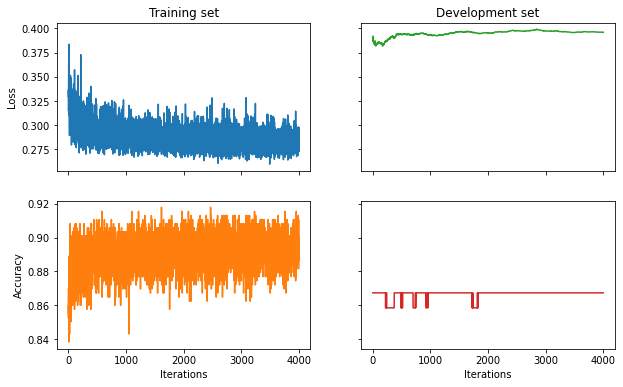

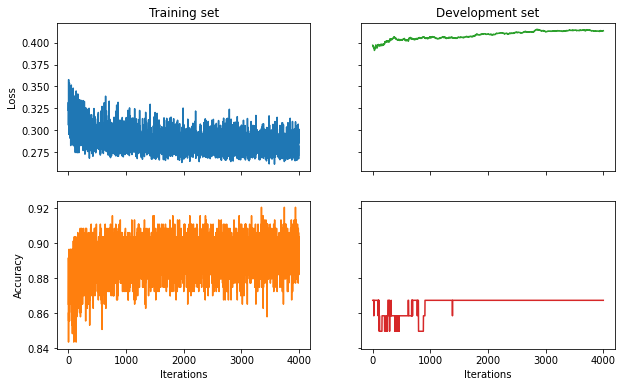

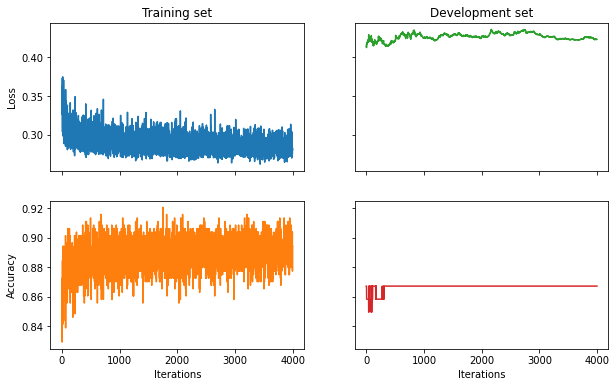

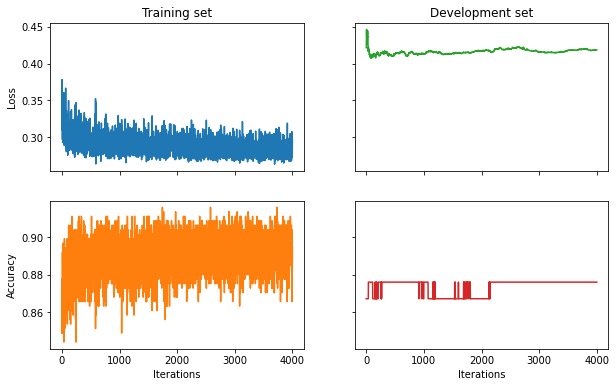

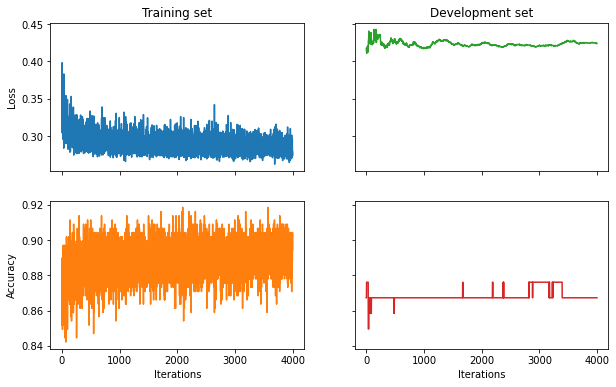

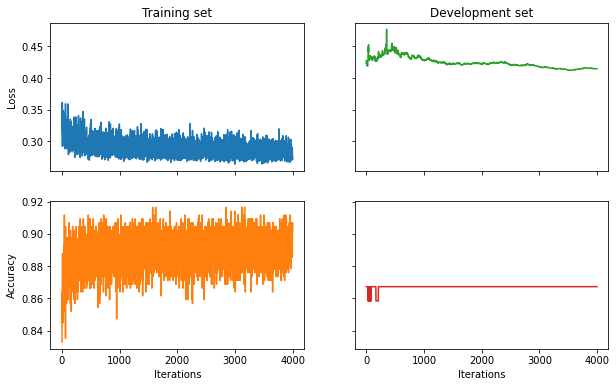

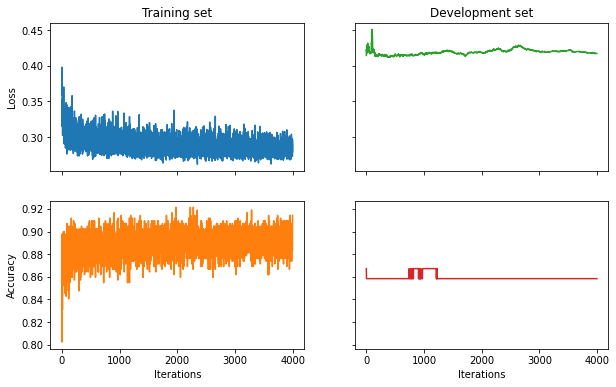

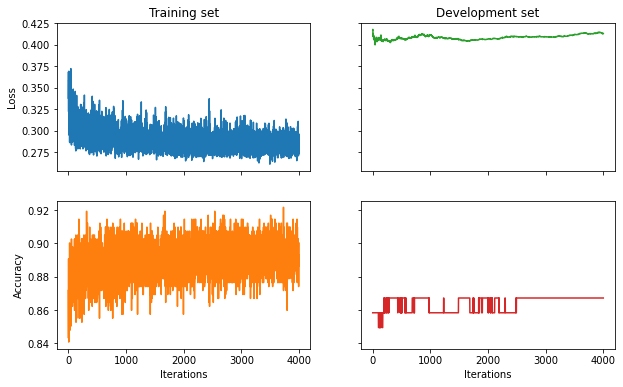

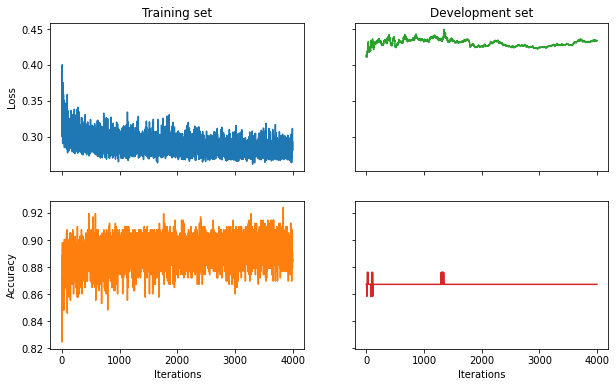

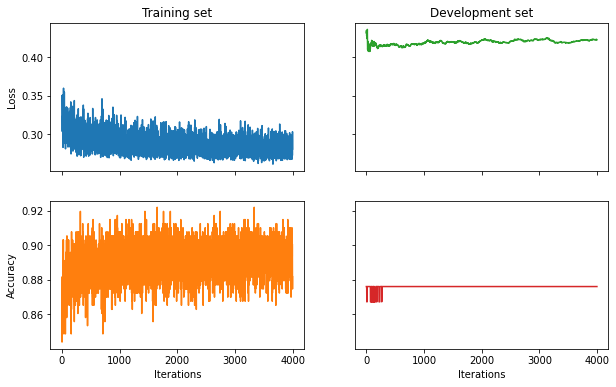

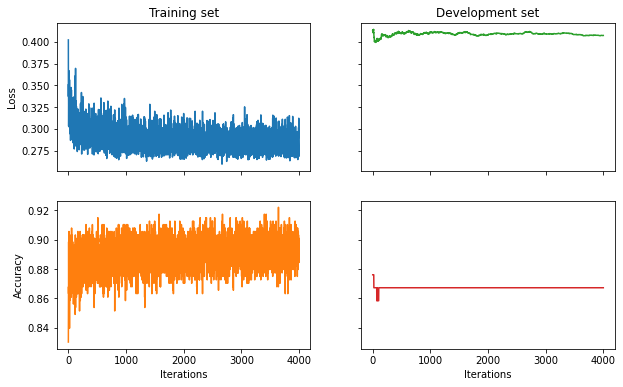

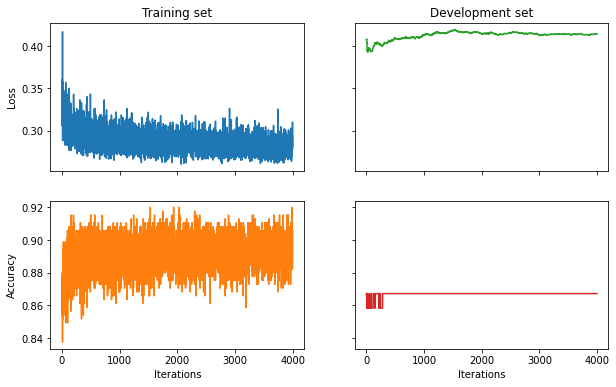

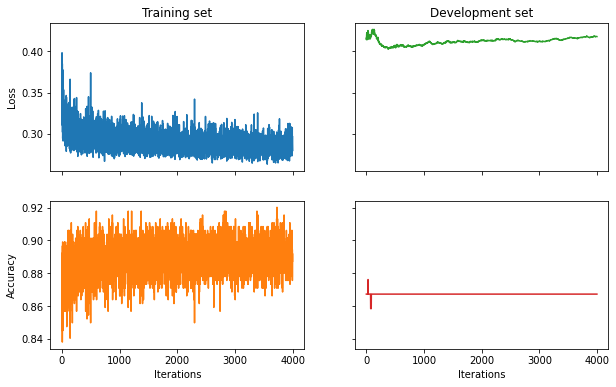

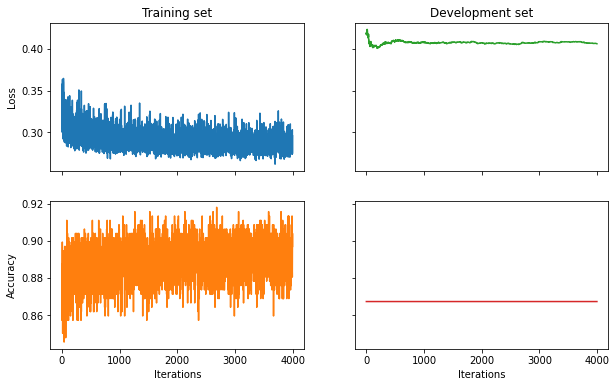

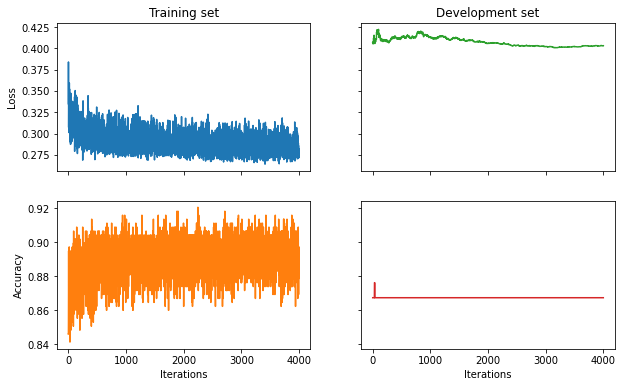

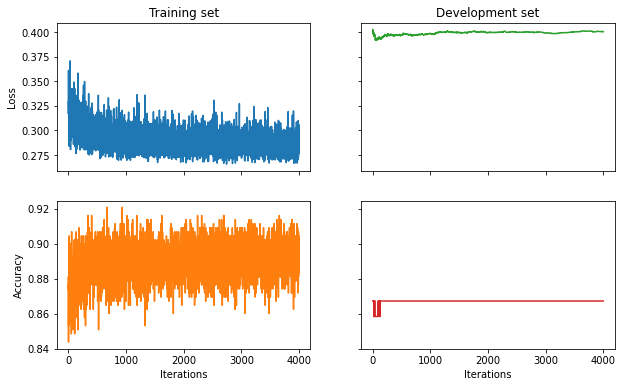

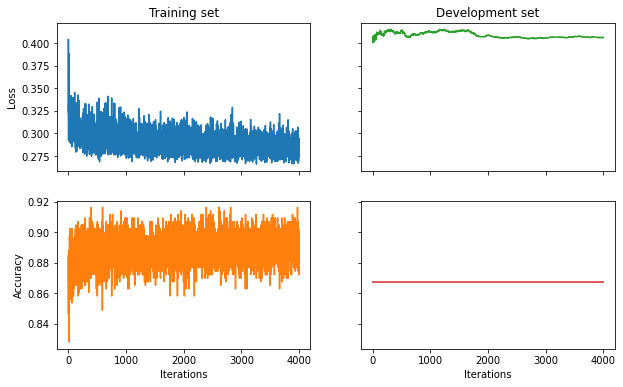

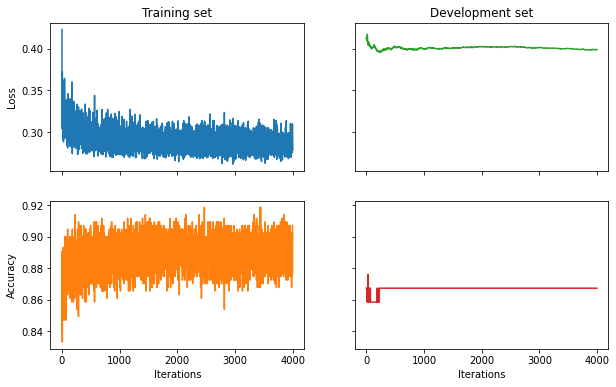

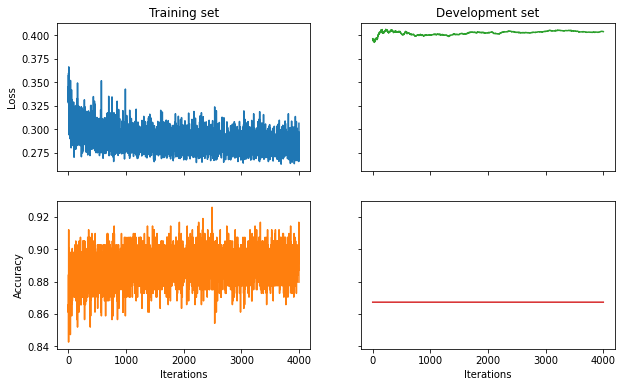

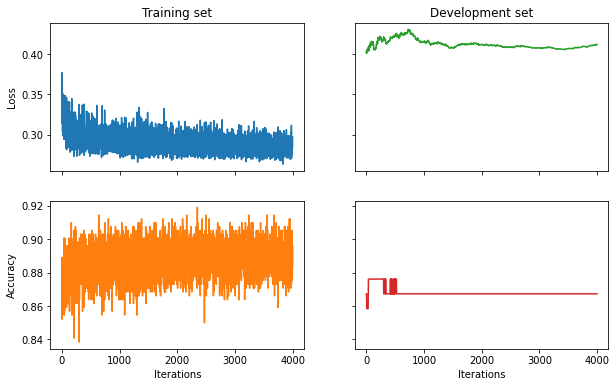

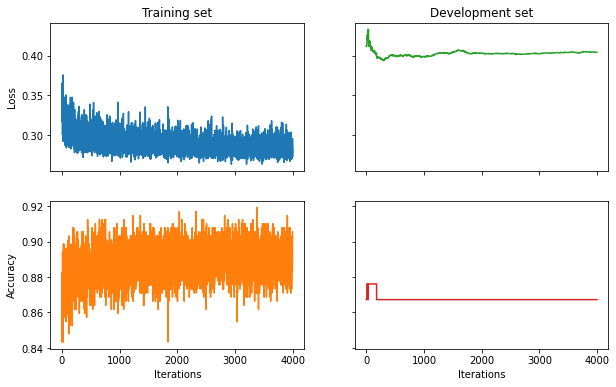

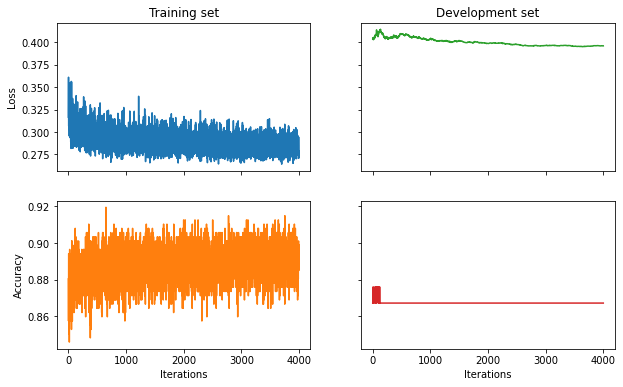

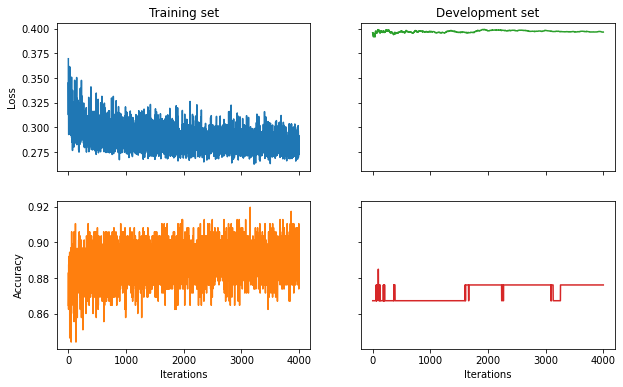

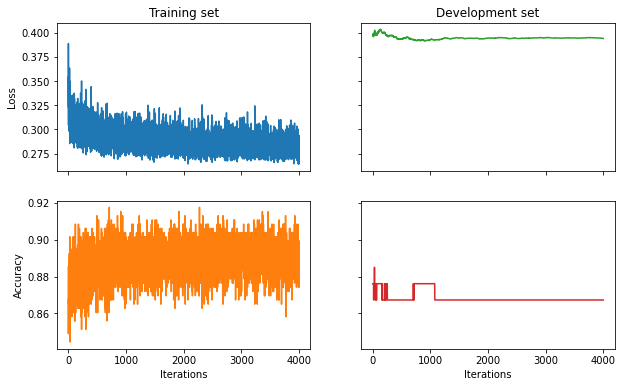

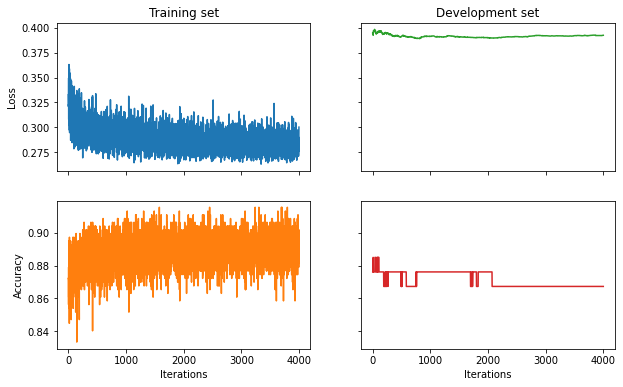

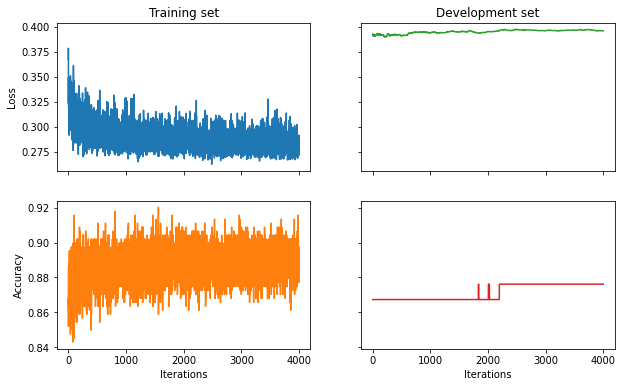

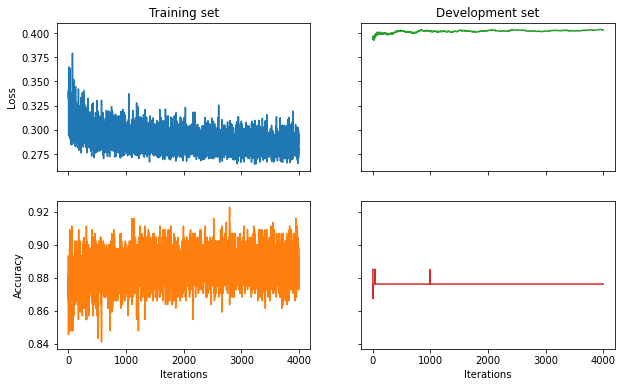

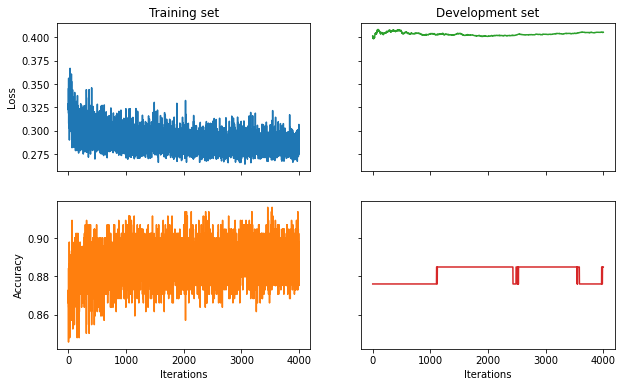

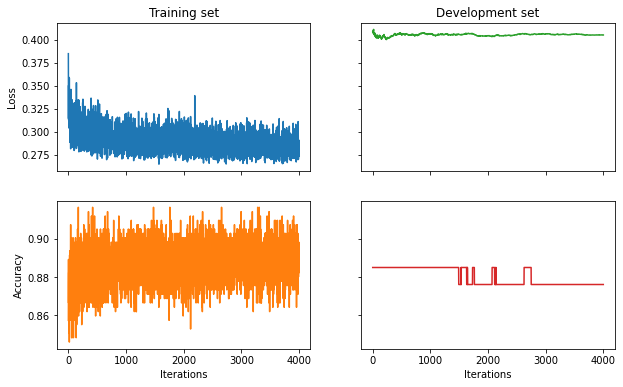

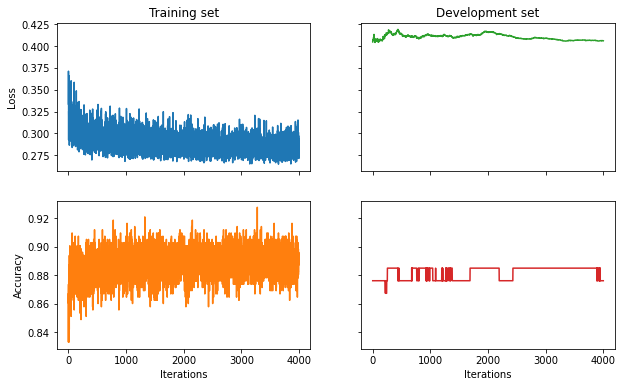

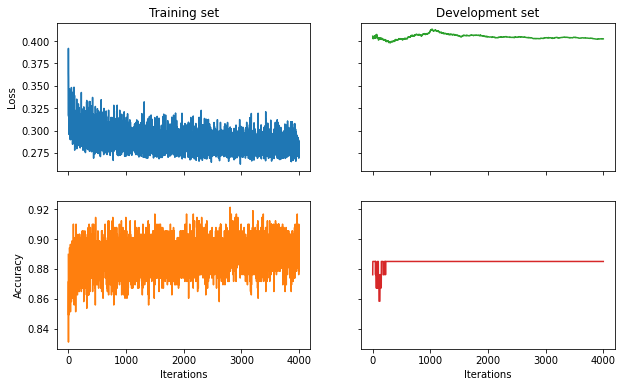

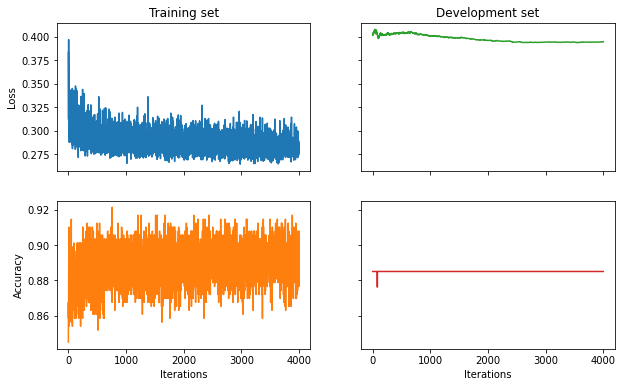

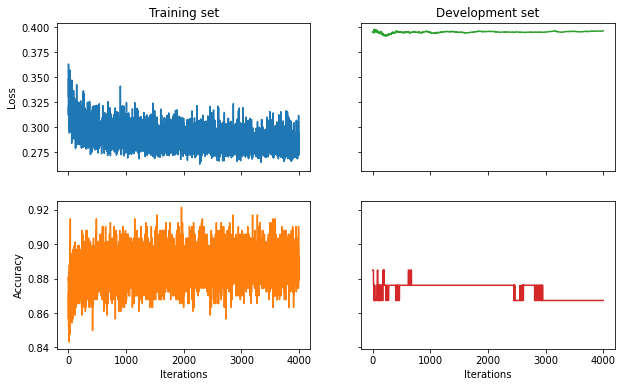

In [9]:
for i, key in enumerate(all_training_keys[initial_number_of_circuits:]):
    print("Progress: ", round((i + initial_number_of_circuits)/len(all_training_keys), 3))
    
    if len(syms) == len(get_symbols(current_training_circuits)) and i > 0:
        if i != len(all_training_keys[1:]):
            current_training_circuits[key] = training_circuits[key]
            new_parameters = sorted(get_symbols({key: training_circuits[key]}), key=default_sort_key)
            if result:
                parameters, init_params_spsa = initialize_parameters(parameters, result.x, new_parameters)
                #continue
            else:
                syms = get_symbols(current_training_circuits)
                parameters = sorted(syms, key=default_sort_key)
                init_params_spsa = np.array(rng.random(len(parameters)))
    else:
        run += 1
    
    # Select those circuits from test and validation circuits which share the parameters with the current training circuits
    current_validation_circuits = select_circuits(current_training_circuits, validation_circuits)
    current_test_circuits = select_circuits(current_training_circuits, test_circuits)
    
    if len(current_validation_circuits) == 0 or len(current_test_circuits) == 0:
        continue
    
    # Create lists with circuits and their corresponding label
    training_circuits_l, training_data_labels_l = construct_data_and_labels(current_training_circuits, training_data_labels)
    validation_circuits_l, validation_data_labels_l = construct_data_and_labels(current_validation_circuits, validation_data_labels)
    test_circuits_l, test_data_labels_l = construct_data_and_labels(current_test_circuits, test_data_labels)
    
    # Limit the number of validation and test circuits to 20% of number of the training circuits
    if limit:
        val_test_circ_size = ceil(len(current_training_circuits))
        if len(current_validation_circuits) > val_test_circ_size:
            validation_circuits_l = validation_circuits_l[:val_test_circ_size]
            validation_data_labels_l = validation_data_labels_l[:val_test_circ_size]
        if len(current_test_circuits) > val_test_circ_size:
            test_circuits_l = test_circuits_l[:val_test_circ_size]
            test_data_labels_l = test_data_labels_l[:val_test_circ_size]
    
    stats = f"Number of training circuits: {len(training_circuits_l)}   "\
        + f"Number of validation circuits: {len(validation_circuits_l)}   "\
        + f"Number of test circuits: {len(test_circuits_l)}   "\
        + f"Number of parameters in model: {len(set([sym for circuit in training_circuits_l for sym in circuit.free_symbols]))}"
    
    with open("results//" + result_file + ".txt", "a") as f:
        f.write(stats + "\n")
    
    print(stats)
    
    train_pred_fn = jit(make_pred_fn(training_circuits_l))
    dev_pred_fn = jit(make_pred_fn(validation_circuits_l))
    test_pred_fn = make_pred_fn(test_circuits_l)
    
    train_cost_fn, train_costs, train_accs = make_cost_fn(train_pred_fn, training_data_labels_l)
    dev_cost_fn, dev_costs, dev_accs = make_cost_fn(dev_pred_fn, validation_data_labels_l)
    
    def callback_fn(xk):
        #print(xk)
        valid_loss = dev_cost_fn(xk)
        train_loss = numpy.around(min(float(train_costs[-1]), float(train_costs[-2])), 4)
        train_acc = numpy.around(min(float(train_accs[-1]), float(train_accs[-2])), 4)
        valid_acc = numpy.around(float(dev_accs[-1]), 4)
        iters = int(len(train_accs)/2)
        if iters % 200 == 0:
            info = f"Epoch: {iters}   "\
            + f"train/loss: {train_loss}   "\
            + f"valid/loss: {numpy.around(float(valid_loss), 4)}   "\
            + f"train/acc: {train_acc}   "\
            + f"valid/acc: {valid_acc}"
        
            with open("results//" + result_file + ".txt", "a") as f:
                f.write(info + "\n")
                
            print(info, file=sys.stderr)
        return valid_loss
    
    a_value = 0.0053
    c_value = 0.0185
            
    train_cost_fn, train_costs, train_accs = make_cost_fn(train_pred_fn, training_data_labels_l)
    dev_cost_fn, dev_costs, dev_accs = make_cost_fn(dev_pred_fn, validation_data_labels_l)

    result = minimizeSPSA(train_cost_fn, x0=init_params_spsa, a = a_value, c = c_value, niter=EPOCHS, callback=callback_fn)
    #result = minimizeCompass(train_cost_fn, x0=init_params_spsa, redfactor=2.0, deltainit=1.0, deltatol=0.001, feps=1e-15, errorcontrol=True, funcNinit=30, funcmultfactor=2.0, paired=True, alpha=0.05, callback=callback_fn)

    figure_path = this_folder + "//results//" + result_file + ".png"
    visualize_result_noisyopt(result, make_cost_fn, test_pred_fn, test_data_labels_l, train_costs, train_accs, dev_costs, dev_accs, figure_path, result_file)
    
    run += 1
    #EPOCHS += 100
    syms = get_symbols(current_training_circuits)
    
    # Extend for the next optimization round
    current_training_circuits[key] = training_circuits[key]
    new_parameters = sorted(get_symbols({key: training_circuits[key]}), key=default_sort_key)
    parameters, init_params_spsa = initialize_parameters(parameters, result.x, new_parameters)